# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
%pip install wordcloud

### Exploratory Data Analysis

In [7]:
# Load the data directly from the current directory
data = pd.read_csv("amazon_alexa.tsv", delimiter='\t', quoting=3)

print(f"Dataset shape: {data.shape}")

Dataset shape: (3150, 5)


In [8]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [9]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [10]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [12]:
#Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [13]:
#We will drop the null record

data.dropna(inplace=True)

In [14]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [15]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [16]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [17]:
# names and datatypes of columns to analyze
data.dtypes  

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

Each review has a star rating from 1 to 5, and it’s stored as an integer.

In [20]:
len(data)

3149

In [21]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


Let's plot the above values in a bar graph

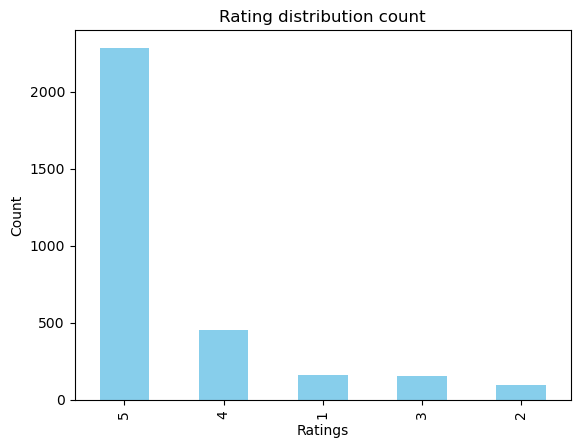

In [23]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color='skyblue')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

### Analyzing 'feedback' column

This column refers to the feedback of the verified review . This is the target variable we are predicting .

In [41]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to each.

In [44]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [46]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

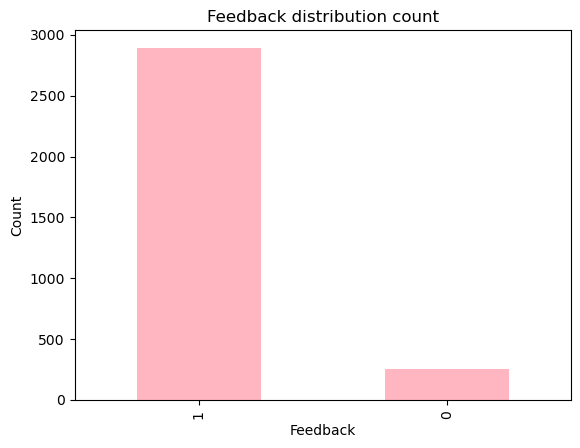

In [51]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color='LightPink')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [34]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

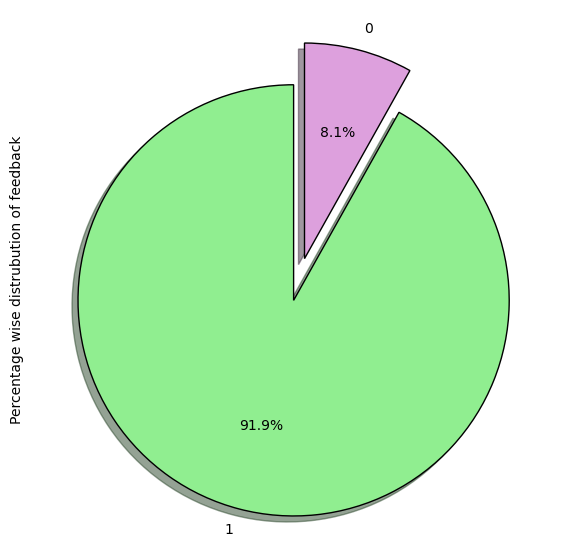

In [53]:
fig = plt.figure(figsize=(7,7))

colors = ('lightgreen', 'plum')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [58]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [61]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [65]:
#Distinct values of 'variation' and its count 

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


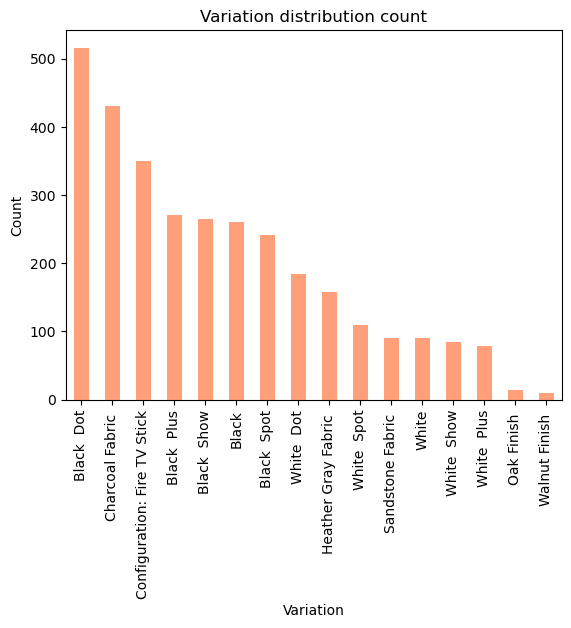

In [67]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'LightSalmon')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

Mean rating according to variation

In [45]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

Let's analyze the above ratings

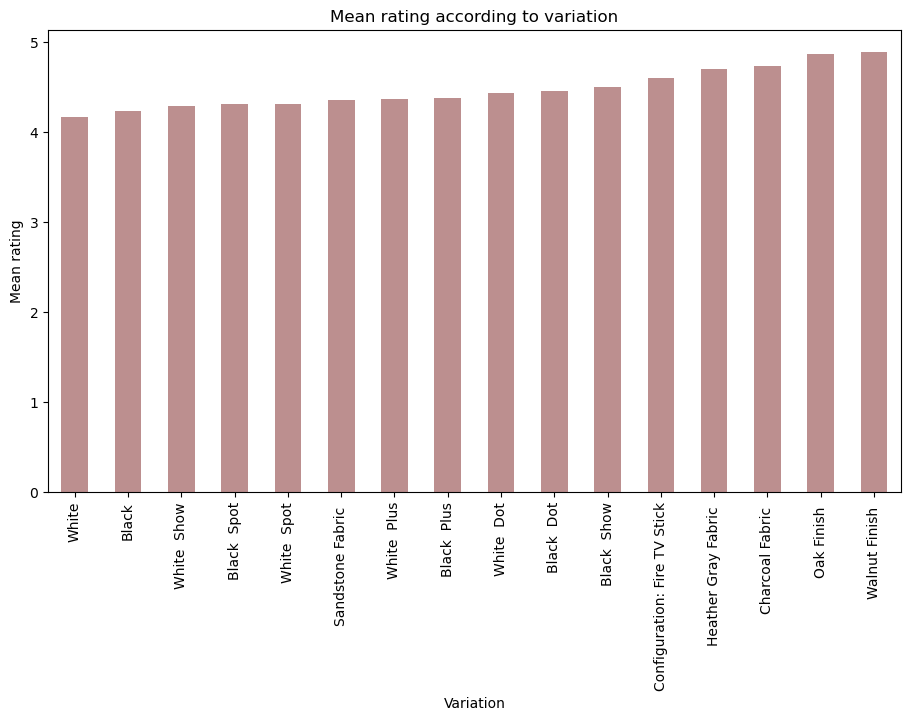

In [71]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'rosybrown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [73]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

Length analysis for full dataset

Lengthwise mean rating

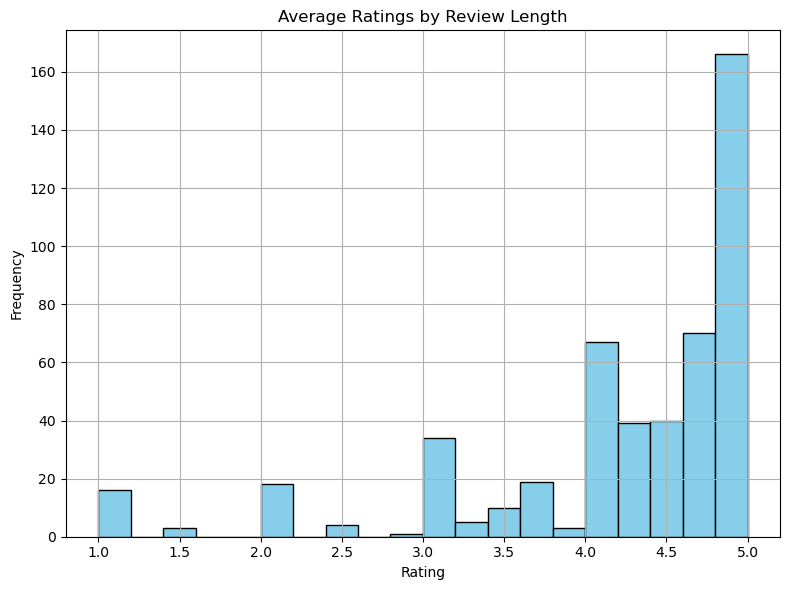

In [79]:
data.groupby('length')['rating'].mean().plot.hist(
    bins=20, color='skyblue', edgecolor='black', figsize=(8, 6)
)
plt.title("Average Ratings by Review Length")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
# Initialize CountVectorizer, removing common English stop words
cv = CountVectorizer(stop_words='english')

# Fit the vectorizer to the 'verified_reviews' and transform the text into a matrix of word counts
words = cv.fit_transform(data.verified_reviews)

Lets find the unique words in each feedback category

In [83]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


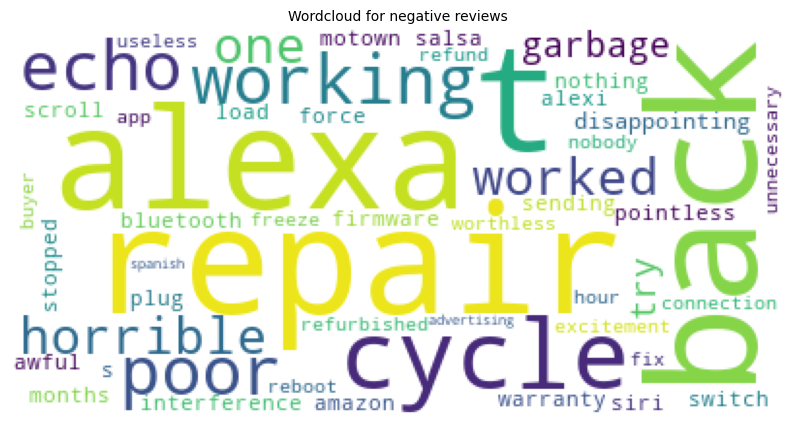

In [86]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

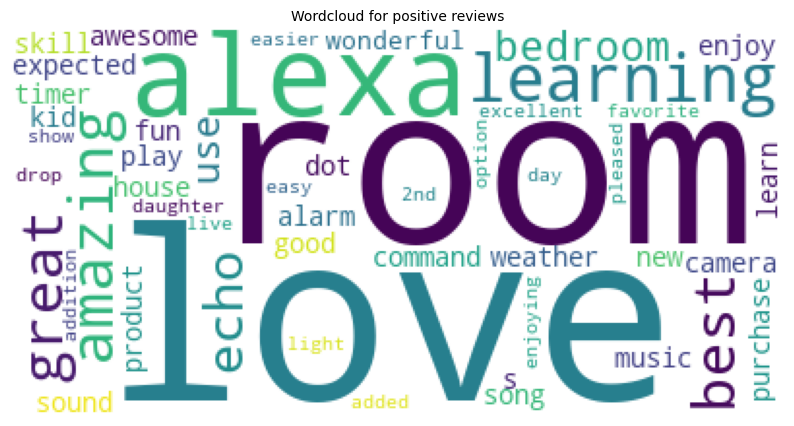

In [89]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [94]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [97]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [99]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [102]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


Splitting data into train and test set with 20% data with testing.

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2519, 2500)
y train: (2519,)
X test: (630, 2500)
y test: (630,)


In [108]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 8


We'll scale X_train and X_test so that all values are between 0 and 1.

In [111]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [113]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

#### Random Forest

In [116]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier(class_weight='balanced')
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier(class_weight='balanced')

In [117]:
# Save model
with open("Models/model_rf.pkl", "wb") as f:
    pickle.dump(model_rf, f)

In [118]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9757840412862246
Testing Accuracy : 0.9126984126984127


In [119]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [124]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

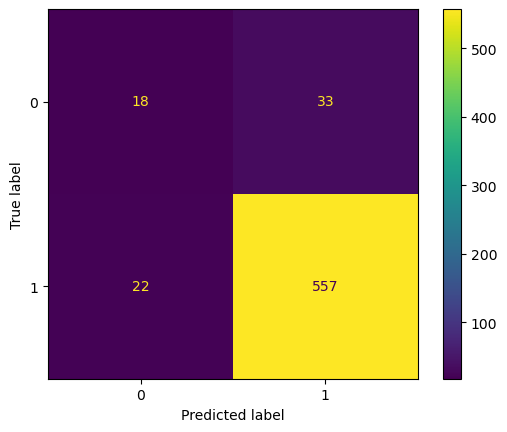

In [126]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [129]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9134604439385317
Standard Variance : 0.012505910772161403


Applying grid search to get the optimal parameters on random forest

In [131]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [132]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [133]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


In [134]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 98.1640048791558
Cross validation mean accuracy on test set : 91.8170166862085
Accuracy score for test set : 0.9126984126984127


#### Decision Tree Classifier

In [136]:
model_dt = DecisionTreeClassifier(class_weight='balanced')
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [137]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9757840412862246
Testing Accuracy : 0.8793650793650793


In [138]:
y_preds = model_dt.predict(X_test)

In [139]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 31  20]
 [ 60 519]]


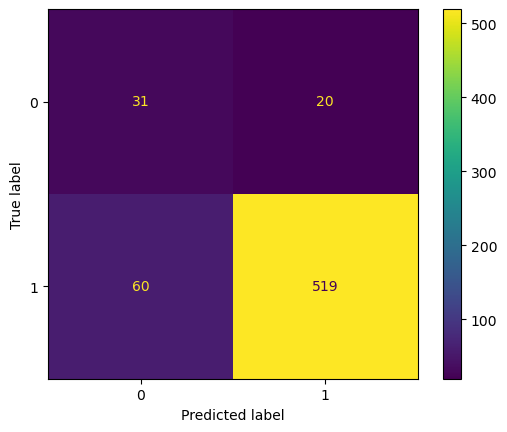

In [140]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()